# Emotion classification using BalanceNet

In [1]:
import csv
import numpy as np
import pandas as pd
import re, sys, os, csv, keras, pickle
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
MAX_NB_WORDS = 40000
MAX_SEQUENCE_LENGTH = 30
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200
GLOVE_DIR = "dataset/glove/glove.twitter.27B.200d.txt"

## Utility functions

In [3]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [4]:
def initial_boost(epoch):
    if epoch==0: return float(8.0)
    elif epoch==1: return float(4.0)
    elif epoch==2: return float(2.0)
    elif epoch==3: return float(1.5)
    else: return float(1.0)

In [5]:
def read_csv(file, lst, cats):
    with open(file, newline='') as f:
        reader = csv.reader(f)
        for i,row in enumerate(reader):
            cat = row[1]
            lst.append(row[0])
            cats.append(int(row[1]))

In [6]:
data = []
cats = []
read_csv("csv_files/data.csv", data, cats)

In [7]:
texts, labels = [], []
with open('csv_files/data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        texts.append(row[0])
        labels.append(row[1])

In [8]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [9]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

In [10]:
labels = to_categorical(np.asarray(labels)) # convert to one-hot encoding vectors

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

## Embeddings

In [11]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
dataWriter = csv.writer(open('csv_files/data_merged.csv', 'w'), delimiter=',',lineterminator="\n")
for n,point in enumerate(data):
    category = cats[n]
    is_happy = category == 3 or category == 5 or category == 6 or category == 7 or category == 9 or category == 11 
    is_neutral = category == 0 or category == 1 or  category == 10
    is_sad = category == 2 or category == 4
    if is_happy:
        dataWriter.writerow([point, 1])
    elif is_neutral:
        dataWriter.writerow([point, 0])
    elif is_sad:
        dataWriter.writerow([point, 2])
    elif category == 8:
        dataWriter.writerow([point, 3])
    elif category == 12:
        dataWriter.writerow([point, 4])
    else:
        print(point,n)

In [13]:
count = 0
with open('csv_files/data_merged.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count+=1
        
count

47266

In [14]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector

In [15]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [16]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [17]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [18]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [19]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [20]:
model = Model(sequence_input, preds)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['accuracy'])

In [21]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint/checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 200)      6872000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 200)      6872000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 12)       9936        ['embedding[0][0]']              
                                                                                              

                                                                                                  
 flatten (Flatten)              (None, 2688)         0           ['dropout_11[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 26)           69914       ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 5)            135         ['dense[0][0]']                  
                                                                                                  
Total params: 13,886,625
Trainable params: 7,014,625
Non-trainable params: 6,872,000
__________________________________________________________________________________________________


In [23]:
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=128,
          callbacks=[model_checkpoints])

Epoch 1/100
296/296 [==============================] - 29s 52ms/step - loss: 1.2048 - accuracy: 0.4785 - val_loss: 1.0801 - val_accuracy: 0.5489
Epoch 2/100
296/296 [==============================] - 13s 44ms/step - loss: 1.0323 - accuracy: 0.5721 - val_loss: 0.9786 - val_accuracy: 0.5981
Epoch 3/100
296/296 [==============================] - 14s 48ms/step - loss: 0.9833 - accuracy: 0.5956 - val_loss: 0.9560 - val_accuracy: 0.6100
Epoch 4/100
296/296 [==============================] - 14s 46ms/step - loss: 0.9558 - accuracy: 0.6061 - val_loss: 0.9439 - val_accuracy: 0.6143
Epoch 5/100
296/296 [==============================] - 15s 51ms/step - loss: 0.9413 - accuracy: 0.6137 - val_loss: 0.9427 - val_accuracy: 0.6141
Epoch 6/100
296/296 [==============================] - 14s 46ms/step - loss: 0.9328 - accuracy: 0.6169 - val_loss: 0.9297 - val_accuracy: 0.6194
Epoch 7/100
296/296 [==============================] - 14s 46ms/step - loss: 0.9221 - accuracy: 0.6239 - val_loss: 0.9248 - val_ac

296/296 [==============================] - 13s 42ms/step - loss: 0.8303 - accuracy: 0.6617 - val_loss: 0.9048 - val_accuracy: 0.6253
Epoch 58/100
296/296 [==============================] - 13s 42ms/step - loss: 0.8315 - accuracy: 0.6643 - val_loss: 0.9029 - val_accuracy: 0.6286
Epoch 59/100
296/296 [==============================] - 13s 43ms/step - loss: 0.8295 - accuracy: 0.6646 - val_loss: 0.9063 - val_accuracy: 0.6254
Epoch 60/100
296/296 [==============================] - 13s 42ms/step - loss: 0.8268 - accuracy: 0.6643 - val_loss: 0.9049 - val_accuracy: 0.6258
Epoch 61/100
296/296 [==============================] - 13s 43ms/step - loss: 0.8301 - accuracy: 0.6622 - val_loss: 0.9049 - val_accuracy: 0.6286
Epoch 62/100
296/296 [==============================] - 13s 43ms/step - loss: 0.8291 - accuracy: 0.6640 - val_loss: 0.9047 - val_accuracy: 0.6241
Epoch 63/100
296/296 [==============================] - 13s 42ms/step - loss: 0.8252 - accuracy: 0.6650 - val_loss: 0.9055 - val_accuracy

In [24]:
pd.DataFrame(model_log.history).to_csv("csv_files/history-balance.csv")

In [25]:
model.save("models/TrainedBalanceNet.h5")

In [26]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('models/model.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\Saransh\AppData\Local\Temp\tmpkkl28vhx\assets


INFO:tensorflow:Assets written to: C:\Users\Saransh\AppData\Local\Temp\tmpkkl28vhx\assets


13957512

## Model Testing and Inference

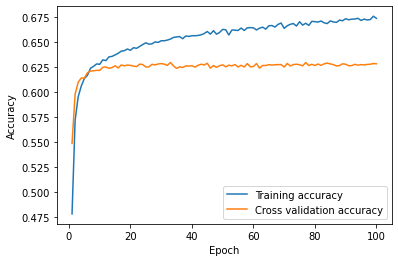

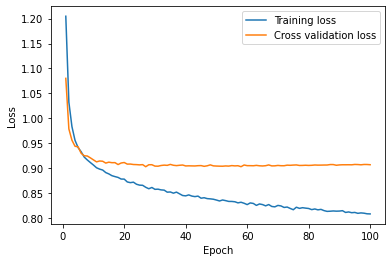

In [27]:
acc = model_log.history['accuracy']
val_acc = model_log.history['val_accuracy']
loss = model_log.history['loss']
val_loss = model_log.history['val_loss']
epochs = np.arange(1, 101, 1)

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Cross validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Cross validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [28]:
classes = ["neutral", "happy", "sad", "hate","anger"]

In [29]:
model_test = load_model('models/TrainedBalanceNet.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [30]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.48      0.36      0.41      1964
       happy       0.64      0.71      0.67      3207
         sad       0.63      0.69      0.66      3191
        hate       0.83      0.71      0.76       883
       anger       0.86      0.69      0.76       212

    accuracy                           0.63      9457
   macro avg       0.69      0.63      0.65      9457
weighted avg       0.62      0.63      0.62      9457



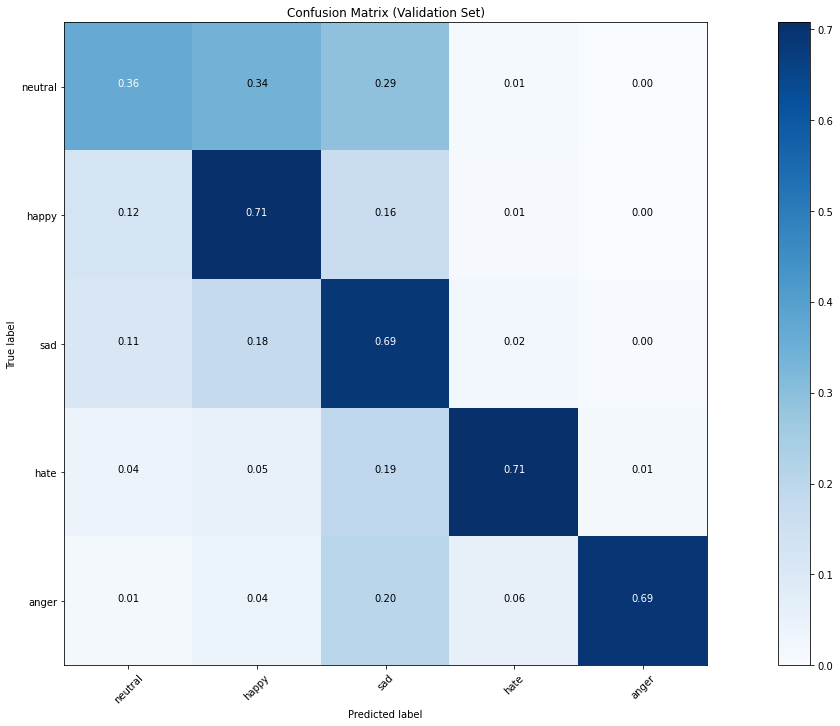

In [31]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)